In [35]:
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.font_manager
import pandas as pd
import numpy as np
import seaborn as sns
from scipy import stats
from datetime import datetime, timedelta

#sklearn functions
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.covariance import EllipticEnvelope
from sklearn.svm import OneClassSVM

from utils import utils
import matplotlib.patches as mpatches 

import warnings

warnings.filterwarnings("ignore")

import tensorflow as tf
import tensorflow_probability as tfp 

tfd = tfp.distributions

[*********************100%***********************]  1 of 1 completed


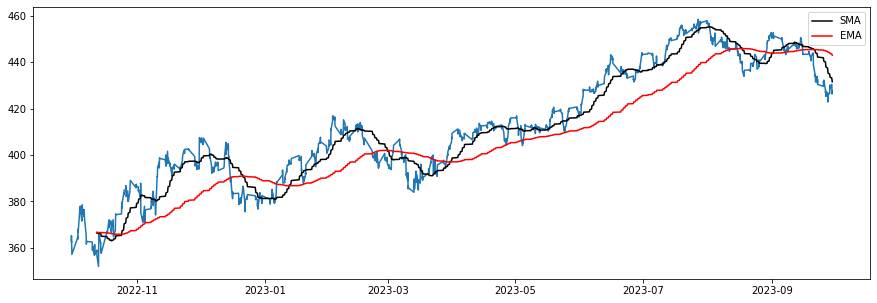

In [ ]:
#downlaod data
ticker = yf.Ticker('SPY')
df =ticker.history(interval = '1h', period = '1y')

#rename the index and reset it
df = df.rename_axis("Date").reset_index()

#create sma
df['sma'] = df['Close'].rolling(60).mean()

ema_period = 120
df['ema'] = df['sma'].ewm(ema_period, adjust = False).mean()


#plot the results
plt.figure(figsize = (15, 5))
plt.plot(df['Date'], df['Close'])
plt.plot(df['Date'], df['sma'], c = 'k', label = 'SMA')
plt.plot(df['Date'], df['ema'], c = 'r', label = 'EMA')
plt.legend()
plt.show()

### Using probabilistic Linear Regression 

In [40]:
#prepare data
#scale data
train_data = df.reset_index(drop = False)
int_cols = ['index', 'Close']

#scaler
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(train_data[int_cols])
train_df_scaled = pd.DataFrame(data_scaled, columns = int_cols)

int_cols = ['index']
train_df_scaled = train_df_scaled.reset_index(drop = False)

x = train_df_scaled[int_cols].to_numpy()
y = train_df_scaled['Close'].to_numpy()

#initialize the model
#negative log likelihood loss
negloglik = lambda y, rv_y: -rv_y.log_prob(y)

#posterior
def posterior_mean_field(kernel_size, bias_size = 0, dtype = None):
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.))
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(2 * n, dtype = dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
        tfd.Normal(loc=t[...,:n],
                  scale=1e-5 + tf.nn.softplus(c+t[...,n])),
        reinterpreted_batch_ndims=1)),
    ])

def prior_trainable(kernel_size, bias_size = 0, dtype = None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
        tfp.layers.VariableLayer(n, dtype = dtype),
        tfp.layers.DistributionLambda(lambda t: tfd.Independent(
        tfd.Normal(loc = t, scale = 1),
        reinterpreted_batch_ndims = 1)),
    ]) 

#initiate model and fit
model = tf.keras.Sequential([
tfp.layers.DenseVariational(1 + 1, posterior_mean_field, prior_trainable, kl_weight = 1/x.shape[0]),
tfp.layers.DistributionLambda(lambda t: tfd.Normal(loc = t[..., :1], 
                                                   scale = 1e-3 + tf.math.softplus(0.01*t[..., 1:]))),
])

model.compile(optimizer = tf.optimizers.Adam(learning_rate=0.01), loss = negloglik)
model.fit(x, y, epochs = 1000, verbose = False)

td = train_data['index'].to_list()
test_df = pd.DataFrame({'index': td, 'Close': td})
test_df_scaled = scaler.transform(test_df)
x_test = test_df_scaled[:, 0]
yhats = [model(x_test.reshape(-1, 1)) for _ in range(100)]

avgm = np.zeros_like(x_test.reshape(-1, 1)[..., 0])
avgs = np.zeros_like(x_test.reshape(-1, 1)[..., 0])

up = np.empty((len(td), 0))
down = np.empty((len(td), 0))
mean = np.empty((len(td), 0))

for i, yhat in enumerate(yhats):
    m = np.squeeze(yhat.mean())
    s = np.squeeze(yhat.stddev())

    mean_concat = np.concatenate((x_test.reshape(-1, 1), m.reshape(-1, 1)), axis = 1)
    mean_ = scaler.inverse_transform(mean_concat)

    std_concat_upper = np.concatenate((x_test.reshape(-1, 1), (m + s).reshape(-1, 1)), axis = 1)
    std_upper = scaler.inverse_transform(std_concat_upper)

    std_concat_lower = np.concatenate((x_test.reshape(-1, 1), (m - s).reshape(-1, 1)), axis = 1)
    std_lower = scaler.inverse_transform(std_concat_lower)

    up = np.hstack((up, std_upper[:, 1].reshape(-1, 1)))
    down = np.hstack((down, std_lower[:, 1].reshape(-1, 1)))
    mean = np.hstack((mean, mean_[:, 1].reshape(-1, 1)))


high_mean = np.mean(up, axis = 1)
low_mean = np.mean(down, axis = 1)
avg = np.mean(mean, axis = 1)


Now we have at each day, 100 data points that represents the stock price.

In [57]:
#print the shapes of up, down and mean
print(f"Shape of up: {up.shape}")
print(f"Shape of down: {down.shape}")
print(f"Shape of mean: {mean.shape}")

Shape of up: (1750, 100)
Shape of down: (1750, 100)
Shape of mean: (1750, 100)


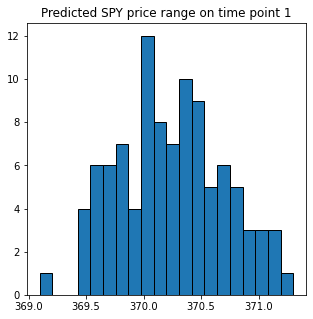

Mean t500: 370.24124521477194
STD t500: 0.4533176202994832


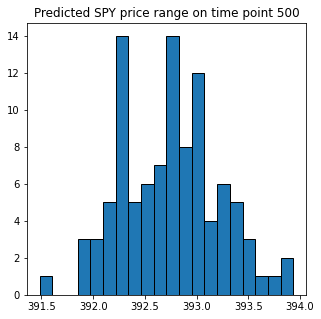

Mean t500: 392.7415174091837
STD t500: 0.4764346745886843


In [63]:
#histogram representing the data distribution of day 1.

plt.figure(figsize = (5, 5))
plt.hist(mean[0, :], bins = 20, edgecolor = 'black')
plt.title('Predicted SPY price range on time point 1')
plt.show()

print(f"Mean t500: {np.mean(mean[0, :])}")
print(f"STD t500: {np.std(mean[0, :])}")

plt.figure(figsize = (5, 5))
plt.hist(mean[500, :], bins = 20, edgecolor = 'black')
plt.title('Predicted SPY price range on time point 500')
plt.show()

print(f"Mean t500: {np.mean(mean[500, :])}")
print(f"STD t500: {np.std(mean[500, :])}")

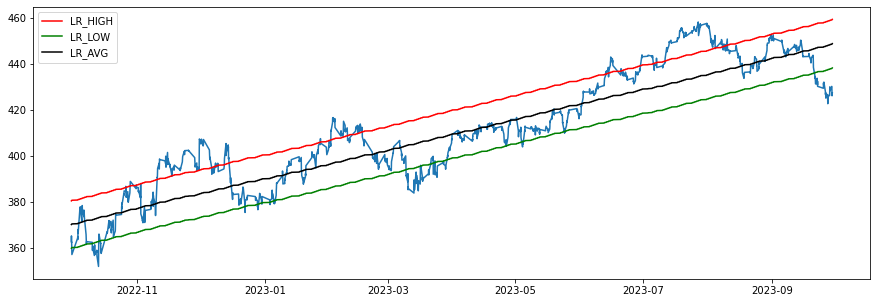

In [42]:
#append to dataframe
df['lr_high'] = high_mean
df['lr_low'] = low_mean
df['lr_avg'] = avg

plt.figure(figsize = (15, 5))
plt.plot(df['Date'], df['Close'])
plt.plot(df['Date'], df['lr_high'], c = 'r', label = 'LR_HIGH')
plt.plot(df['Date'], df['lr_low'], c = 'g', label = 'LR_LOW')
plt.plot(df['Date'], df['lr_avg'], c = 'k', label = 'LR_AVG')
plt.legend()
plt.show()

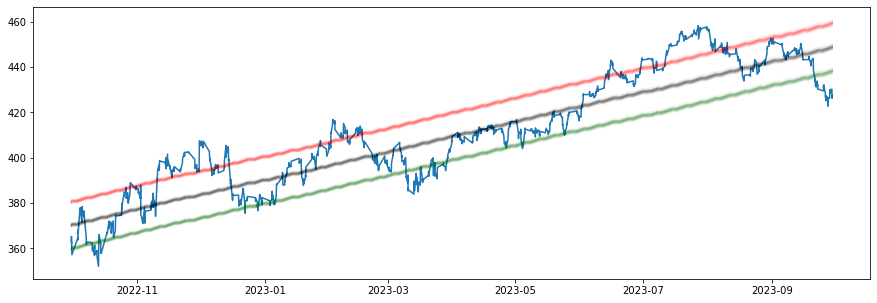

In [65]:
plt.figure(figsize = (15, 5))
plt.plot(df['Date'], df['Close'])
plt.plot(df['Date'], up, c = 'r', alpha = 0.01)
plt.plot(df['Date'], down, c = 'g', alpha = 0.01)
plt.plot(df['Date'], mean, c = 'k', alpha = 0.01)
plt.show()

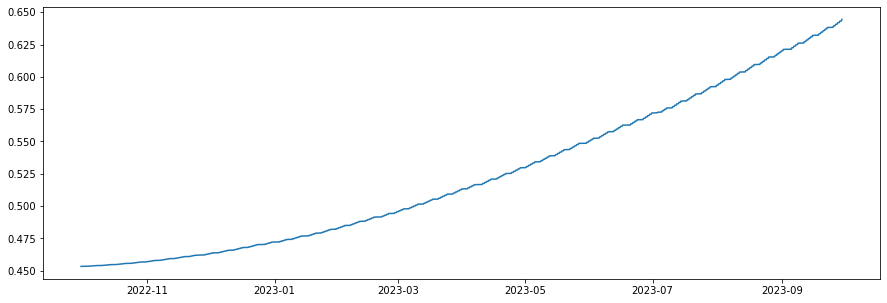

In [56]:
#standard deviation of the avg changing over time
plt.figure(figsize = (15, 5))
plt.plot(df['Date'], np.std(mean, axis = 1))
plt.show()